## Background
This example demonstrates the use of MUQ's implementation of parallel tempering for sampling multimodal distributions.  Here, the distribution is the posterior distribution from a 1d Bayesian inference with cosine forward model.  In particular, we consider a parameter $x\in\mathbb{R}$ and with a Gaussian prior distribution with mean $0$ and variance $25$.    The forward model is given by

$$
f(x) = cos(x)
$$

and the likelihood function is constructed from an additivate Gaussian model 

$$
y = f(x) + \epsilon
$$

where $\epsilon\sim N(0,0.1^2)$.



### Imports

In [1]:
import muq.Modeling as mm
import muq.SamplingAlgorithms as ms

import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Image

### Define and plot the forward model

In [2]:
nplot = 1000
x = np.linspace(-15,15,nplot)

mod = mm.CosOperator(1)

f = [mod.Evaluate([x[i:i+1]])[0][0] for i in range(nplot)]

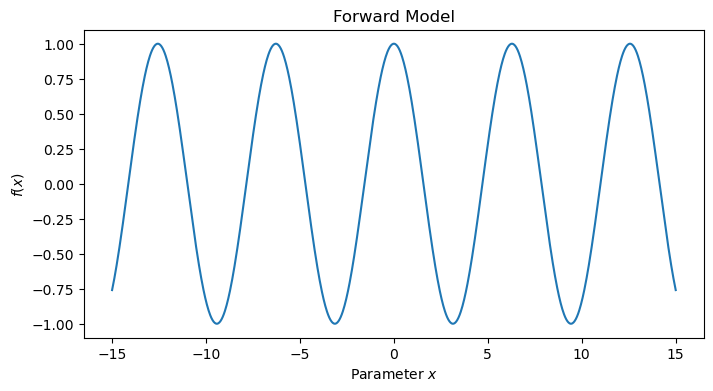

In [3]:
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(x,f)
plt.title('Forward Model')
plt.xlabel('Parameter $x$')
plt.ylabel('$f(x)$')
plt.show()

### Define observational data 
Here we assume that an observation of $y=\frac{1}{2}$ is available.  We assume observation noise with variance $\sigma_\epsilon=0.1^2$.

In [4]:
obs_val = np.array([0.5])
obs_var = np.array([0.1**2])

### Construct Prior Distribution

In [5]:
prior_mu = np.array([0.0])
prior_var = np.array([5.0**2])
prior = mm.Gaussian(prior_mu,prior_var)

### Define the Posterior Distribution

In [6]:
graph = mm.WorkGraph()

# Add the forward model
graph.AddNode(mod, 'f(x)')

# Add the prior 
graph.AddNode(prior.AsDensity(), 'Prior')

# Add an exponential transformation of the log parameters
graph.AddNode(mm.IdentityOperator(1), 'x')
graph.AddEdge('x', 0, 'f(x)', 0)
graph.AddEdge('x', 0, 'Prior', 0)

# Define the likelihood function
likelihood = mm.Gaussian(obs_val, obs_var)
graph.AddNode(likelihood.AsDensity(),'Likelihood')
graph.AddEdge('f(x)',0,'Likelihood',0)

# Define the posterior
graph.AddNode(mm.DensityProduct(2),'Posterior')
graph.AddEdge('Prior',0,'Posterior',0)
graph.AddEdge('Likelihood',0,'Posterior',1)

### Plot the Prior, Likelihood, and Posterior density

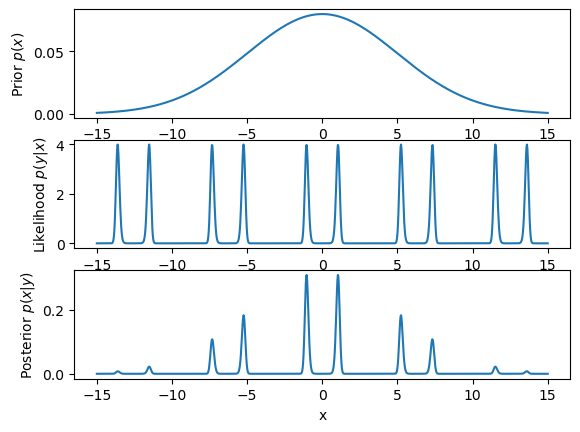

In [7]:
likely = graph.CreateModPiece("Likelihood")
prior_dens = prior.AsDensity()

prior_logdens = np.array([prior.LogDensity([x[i:i+1]]) for i in range(nplot)])
loglikely_vals = np.array([likely.Evaluate([x[i:i+1]])[0][0] for i in range(nplot)])
post_logdens = prior_logdens + loglikely_vals

fig, axs = plt.subplots(nrows=3)
axs[0].plot(x,np.exp(prior_logdens))
axs[0].set_ylabel('Prior $p(x)$')

axs[1].plot(x,np.exp(loglikely_vals))
axs[1].set_ylabel('Likelihood $p(y|x)$')

axs[2].plot(x,np.exp(post_logdens))
axs[2].set_ylabel('Posterior $p(x|y)$')
axs[2].set_xlabel('x')

plt.show()

## Construct sampler via Options Dictionary
There are two primary ways to construct MCMC samplers in MUQ:

1. Through a dictionary (or a boost::property_tree in C++)
2. By manually assembling proposals, kernels, and chains.

In this section, we define a parallel tempering sampler via a dictionary.  This means that all the kernels and proposals are defined through strings.   The next section will reconstruct the sampler by assembling proposal, kernel, and chain objects.

In [8]:

opts = {
    "NumSamples" : 1e5, 
    "PrintLevel" : 2,
    "Inverse Temperatures":"0.0,0.25,0.5,0.75,1.0",
    "Swap Increment": 100,
    "Swap Type": "DEO",
    "Adapt Start": 1000,
    "Kernel Lists" : "Kernel0;Kernel1;Kernel1;Kernel1;Kernel1",
    "Kernel0.Method" : "MHKernel",
    "Kernel0.Proposal" : "PropOpts0",
    "Kernel0.PropOpts0.Method" : "IndependenceProposal",
    "Kernel0.PropOpts0.ProposalVariance": prior_var[0],
    "Kernel1.Method" : "MHKernel",
    "Kernel1.Proposal" : "PropOpts1",
    "Kernel1.PropOpts1.Method" : "MHProposal",
    "Kernel1.PropOpts1.ProposalVariance": 0.25,
}

prob = ms.InferenceProblem(likely, prior_dens)

sampler = ms.ParallelTempering(opts, prob)

x0 = prior.Sample()
numChains = len(opts['Kernel Lists'].split(';'))

samps = sampler.Run([x0]*numChains)

Starting parallel tempering sampler...
  10% Complete
    Avg. Swap Probs: 0.59  0.8 0.43 0.25
    Inverse Temps:       0 0.042 0.084  0.21     1
    Kernel 0:
      Block 0:
      MHKernel acceptance Rate = 100%
  20% Complete
    Avg. Swap Probs: 0.62 0.76 0.53 0.73
    Inverse Temps:       0 0.034  0.13  0.45     1
    Kernel 0:
      Block 0:
      MHKernel acceptance Rate = 100%
  30% Complete
    Avg. Swap Probs: 0.56  0.7 0.67 0.76
    Inverse Temps:       0 0.034  0.13  0.45     1
    Kernel 0:
      Block 0:
      MHKernel acceptance Rate = 100%
  40% Complete
    Avg. Swap Probs: 0.69 0.68 0.64 0.73
    Inverse Temps:       0 0.026  0.12  0.37     1
    Kernel 0:
      Block 0:
      MHKernel acceptance Rate = 100%
  50% Complete
    Avg. Swap Probs: 0.61 0.67  0.6 0.66
    Inverse Temps:       0 0.026  0.12  0.37     1
    Kernel 0:
      Block 0:
      MHKernel acceptance Rate = 100%
  60% Complete
    Avg. Swap Probs: 0.61  0.7 0.61 0.69
    Inverse Temps:       0 0.026  0

#### Plot the MCMC results

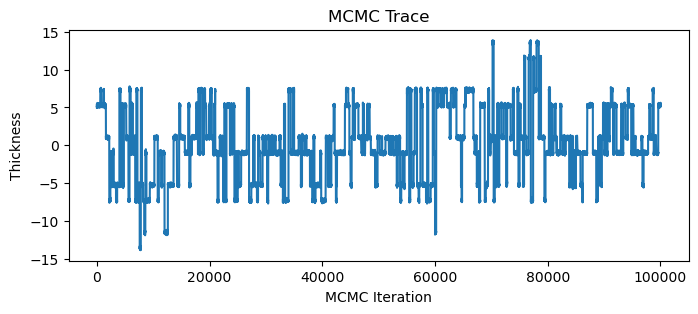

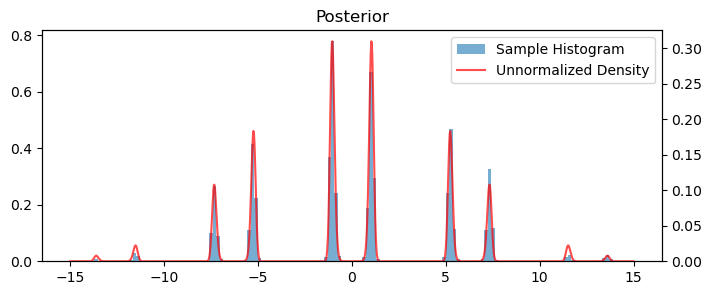

In [9]:

sampMat = samps.AsMatrix()[0]


fig, ax = plt.subplots(figsize=(8,3))
ax.plot(sampMat)
ax.set_ylabel('Thickness')
ax.set_xlabel('MCMC Iteration')
ax.set_title('MCMC Trace')

fig, ax = plt.subplots(figsize=(8,3))
ax2 = ax.twinx()
_,_,h = ax.hist(sampMat,150,alpha=0.6,density=True)
l = ax2.plot(x,np.exp(post_logdens),'r',alpha=0.7)
ax.set_title('Posterior')

ax2.set_ylim(0,ax2.get_ylim()[1])

lns = [h]+l
labs = ['Sample Histogram', 'Unnormalized Density']
ax.legend(lns, labs, loc=0)

plt.show()

## Assemble sampler with kernel objects

Here we repeat the MCMC sampling from above but construct the parallel tempering sampler by manually constructing proposal and kernel objects.  The `ParallelTempering` class accepts a list of transition kernels for each chain and a vector of temperatures defining the target density for each chain.   MUQ implements the method described in [[Syed et al., 2021](https://arxiv.org/pdf/1905.02939.pdf)].  Details can be found in that paper.

In [10]:
numChains = 5
invTemps = np.linspace(0,1,numChains)
propSizes = np.linspace(10.0,0.5,numChains)


problem = ms.InferenceProblem(likely, prior_dens)

# Define the proposals, using the prior at an inverse temperature of 0
proposals = []
proposals.append( ms.IndependenceProposal(dict({}), problem, prior) )
for i in range(1,numChains):
    propOpts = dict({'ProposalVariance' : propSizes[i]})
    proposals.append( ms.MHProposal(propOpts, problem.Clone()))
    
# Define Metropolis-Hastings kernels for each chain
kernels = []
kernOpts = dict({'PrintLevel' : 2})   
for i in range(numChains):
    kernels.append( ms.MHKernel(kernOpts, problem.Clone(), proposals[i]) )
    
# Define the parallel tempering algorithm
chainOpts = dict({
    'PrintLevel' : 2,
    'NumSamples' : 1e5,
    'Swap Increment': 100,
    'Swap Type': 'DEO',
    'Adapt Start': 1000
})
sampler = ms.ParallelTempering(chainOpts, invTemps, kernels)

x0 = prior.Sample()
samps = sampler.Run([x0]*numChains)

Starting parallel tempering sampler...
  10% Complete
    Avg. Swap Probs: 0.38 0.39 0.94 0.88
    Inverse Temps:       0 0.057  0.19  0.38     1
    Kernel 0:
      Block 0:
      MHKernel acceptance Rate = 100%
  20% Complete
    Avg. Swap Probs: 0.59 0.69 0.52 0.65
    Inverse Temps:       0 0.034   0.1  0.34     1
    Kernel 0:
      Block 0:
      MHKernel acceptance Rate = 100%
  30% Complete
    Avg. Swap Probs: 0.57 0.76 0.57 0.64
    Inverse Temps:       0 0.034   0.1  0.34     1
    Kernel 0:
      Block 0:
      MHKernel acceptance Rate = 100%
  40% Complete
    Avg. Swap Probs: 0.62 0.73 0.54 0.69
    Inverse Temps:       0 0.029  0.13  0.36     1
    Kernel 0:
      Block 0:
      MHKernel acceptance Rate = 100%
  50% Complete
    Avg. Swap Probs: 0.64 0.62 0.65 0.67
    Inverse Temps:       0 0.029  0.13  0.36     1
    Kernel 0:
      Block 0:
      MHKernel acceptance Rate = 100%
  60% Complete
    Avg. Swap Probs: 0.64 0.64 0.61 0.69
    Inverse Temps:       0 0.029  0

#### Plot the MCMC results

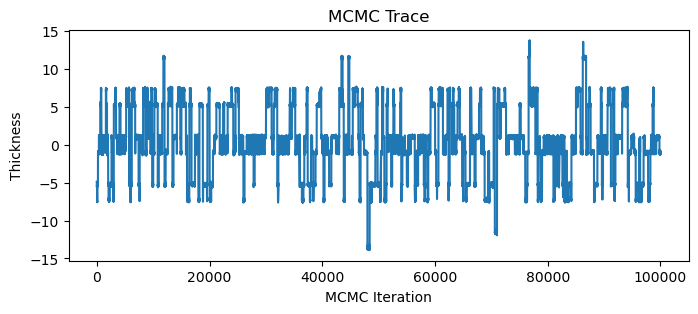

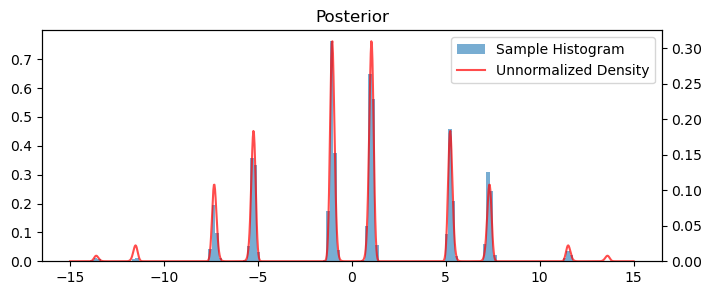

In [11]:
sampMat = samps.AsMatrix()[0]

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(sampMat)
ax.set_ylabel('Thickness')
ax.set_xlabel('MCMC Iteration')
ax.set_title('MCMC Trace')

fig, ax = plt.subplots(figsize=(8,3))
ax2 = ax.twinx()
_,_,h = ax.hist(sampMat,150,alpha=0.6,density=True)
l = ax2.plot(x,np.exp(post_logdens),'r',alpha=0.7)
ax.set_title('Posterior')

ax2.set_ylim(0,ax2.get_ylim()[1])

lns = [h]+l
labs = ['Sample Histogram', 'Unnormalized Density']
ax.legend(lns, labs, loc=0)

plt.show()